In [1]:
# %matplotlib widget

In [1]:
import json
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset, Dataset
from tqdm import tqdm
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers.pipelines import PIPELINE_REGISTRY
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import pandas as pd

from rep_reader_pipeline import RepReaderPipeline

# Configurations
warnings.filterwarnings("ignore")
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

PIPELINE_REGISTRY.register_pipeline(
    "rep",
    pipeline_class=RepReaderPipeline,
    pt_model=AutoModel,
)

2023-09-25 01:29:37.328032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 01:29:38.761910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[2023-09-25 01:29:41,679] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /data/long_phan/anaconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/data/long_phan/anaconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /data/long_phan/anaconda3 did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/data/long_phan/anaconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/data/long_phan/anaconda3/etc/xml/catalog file'), PosixPath('file')}
  warn(msg)
/data/long_phan/anaconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('() {  eval `/usr/bin/modulecmd bash $*`\n}')}
  warn(msg)
/data/long_phan/anaconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath(' /nfs/cluster/spack/bin/spack;\n _spack_

In [2]:
model_name_or_path = "/data/private_models/cais_models/llama-2/llama/llama-2-13b-chat-hf/"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

rep_pipeline =  pipeline("rep", model=model, tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
ice_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reader_kwargs = {"n_components": 3}

In [6]:
from data_utils import load_utility
template_str = 'Consider the amount of happiness in the following scenario:\nScenario: {scenario}\nThe amount of happiness in the scenario is '
# test_template_str = '{scenario}'

test_template_str = 'Consider the amount of happiness in the following scenario:\nScenario: {scenario}\nThe amount of happiness in the scenario is '


train_dataset, test_dataset, train_labels, group_sizes = load_utility(
            train_template_str=template_str, 
            test_template_str=test_template_str, 
            max_train_samples=75,
            data_dir="../ethics/ranking_datasets/util/"
        )

In [5]:
ice_token = -1
rep_reader = rep_pipeline.get_directions(
    train_dataset['inputs'], 
    ice_token=ice_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=train_labels, 
    direction_method=direction_method,
    direction_finder_kwargs=rep_reader_kwargs,
)

In [6]:
H_tests_components = {}
for i in tqdm(range(3)):
    H_tests = rep_pipeline(
        test_dataset['inputs'][:300], 
        ice_token=-1, 
        hidden_layers=hidden_layers, 
        rep_reader=rep_reader,
        component_index=i,
        batch_size=32)
    H_tests_components[i] = H_tests

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.14s/it]


max layer: -31


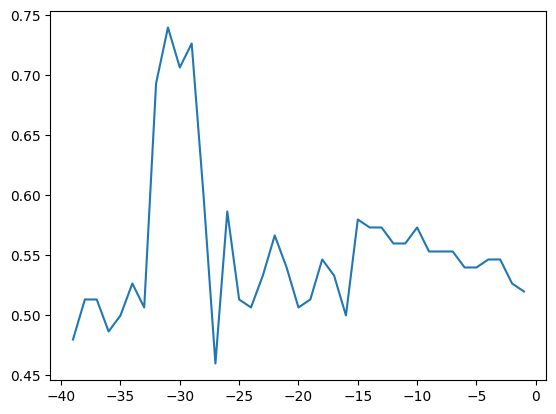

In [209]:
results = {layer: {} for layer in hidden_layers}

component = 2
H_tests =  H_tests_components[component]
max_cors = 0
max_layers = None
for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests] 
    # print(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = rep_reader.direction_signs[layer][component]

    eval_func = min if sign == -1 else max    
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors
    if cors > max_cors:
        max_layers=layer
        max_cors=cors

print("max layer:",max_layers) 
plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()


In [9]:
from transformers import AutoModelForSequenceClassification

DEVICE = 'cuda'

def load(model, load_path=None):
    name = model
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=1).half().to(DEVICE)

    if load_path is not None:
        model.load_state_dict(torch.load(load_path), strict=False)

    return model.eval(), tokenizer
cls_model, cls_tokenizer = load('microsoft/deberta-v3-large', '/data/private_models/cais_models/proxy_models/util_deberta-v3-large_5e-06_32_2.pkl')

prompt = ['I got an ice cream and I am happy.', 'I hit my head.']
prompts = [
    "I went to school today, and I reconnected with friends, had engaging discussions in class, and even enjoyed a delicious lunch in the cafeteria.",
    "I went to school today, and I tackled my assignments efficiently, received positive feedback from my teacher, and left with a sense of accomplishment.",
    "I went to school today, and I won a prize in the essay competition, made a new friend in biology, and discovered an interesting book in the library.",
    "I went to school today, and the sun was shining brightly, my favorite song played during break, and my team won the inter-class debate.",
]
inputs = cls_tokenizer(prompt, return_tensors='pt', padding=True).to(DEVICE)
outputs = cls_model(**inputs)
print(outputs.logits)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[ 9.1406],
        [-1.5889]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)


In [10]:
pos_uti = [
    "I went to school today, and I reconnected with friends, had engaging discussions in class, and even enjoyed a delicious lunch in the cafeteria.",
    "I went to school today, and I tackled my assignments efficiently, received positive feedback from my teacher, and left with a sense of accomplishment.",
    "I went to school today, and I won a prize in the essay competition, made a new friend in biology, and discovered an interesting book in the library.",
    # "I went to school today, and I was complimented for my outfit, enjoyed the guest lecture immensely, and the canteen served my favorite dish.",
    # "I went to school today, and the sun was shining brightly, my favorite song played during break, and my team won the inter-class debate.",
    # "I went to school today, and I found money on the ground, had a productive group study session, and was chosen as the class representative.",
    # "I went to school today, and my lost pen was returned by a kind junior, I understood a challenging topic, and shared a laugh with my classmates.",
    # "I went to school today, and I finally mastered a difficult concept, sang in the school choir, and took beautiful photos for the yearbook.",
    "I went to school today, and I was greeted warmly by everyone, scored well in a surprise test, and found a club that matched my interests.",
    "I went to school today, and we had a fun sports session, my presentation was praised, and I got to leave early for a school event.",
    # "I went to school today, and I learned about an inspiring historical figure, my artwork was showcased, and received a kind note from a friend.",
    "I went to school today, and my favorite teacher told a motivating story, I played a new game, and felt a sense of camaraderie with my peers.",
    "I went to school today, and I helped someone with their homework, got invited to a weekend study group, and the day ended with a soothing music session.",
    "I went to school today, and I bonded with my benchmate, the teacher used an innovative teaching method, and we planned a class outing.",
    "I went to school today, and I got a front seat in the auditorium, was chosen for the school play, and had a peaceful reading session in the library.",
    "I went to school today, and the class had a collaborative project, my ideas were appreciated, and the teacher played a fun educational game.",
    "I went to school today, and I received a certificate of excellence, had a hearty conversation with my mentor, and practiced for the school band.",
    "I went to school today, and I exchanged books with a friend, participated in a science experiment, and got selected for the interschool quiz.",
    "I went to school today, and I was thrilled to be part of a field trip planning committee, shared innovative ideas, and had a hearty lunch with pals.",
    "I went to school today, and I celebrated a classmate's birthday, aced the math quiz, and enjoyed a peaceful moment in the garden.",
    "I went to school today, and I took initiative in class discussions, collaborated well with teammates, and the day concluded with a motivational speech.",
    "I went to school today, and I enjoyed the morning assembly's performance, completed a group assignment successfully, and was acknowledged for my efforts.",
    "I went to school today, and I started a new exciting project, engaged in a thoughtful debate, and left with new books from the library.",
    "I went to school today, and I was greeted with a surprise class party, shared stories with classmates, and finished all my homework.",
    "I went to school today, and I was selected as a group leader, came up with innovative solutions, and enjoyed the evening cultural fest.",
    "I went to school today, and I got appreciated for my leadership skills, took part in an art workshop, and tried out a new sport.",
    "I went to school today, and we had an enlightening discussion about global issues, I made insightful contributions, and the school magazine published my article.",
    "I went to school today, and I enjoyed a fun-filled recess with friends, participated actively in the drama class, and got a positive note from my counselor.",
    "I went to school today, and I was delighted to be appointed as the student ambassador, discussed a new community project, and helped in organizing a charity event.",
    "I went to school today, and we danced in the rain during our sports hour, I shared my umbrella with a new student, and we became friends instantly.",
    "I went to school today, and the weather was perfect for a day out, we had a picnic in the school yard, and I discovered a hidden talent in sketching.",
    "I went to school today, and I was inspired by a guest speaker, started a journal to note down my thoughts, and felt grateful for the supportive staff.",
    "I went to school today, and I initiated a reading challenge, watched an inspiring documentary in class, and enjoyed the aroma of blooming flowers on campus.",
    "I went to school today, and I had a delightful conversation about future goals with my peers, learned a new hobby, and felt at peace during meditation class.",
    "I went to school today, and I explored the school's nature trail, documented various flora and fauna, and captured the beauty of sunrise with my camera.",
    "I went to school today, and we had a surprise talent show, I sang my heart out, and the applause was heartwarming.",
    "I went to school today, and I contributed to the class project with innovative ideas, learned pottery during art class, and felt content at day's end.",
    "I went to school today, and I organized a quiz competition, enjoyed a chocolate treat during lunch, and felt proud seeing our class bulletin board.",
    "I went to school today, and I got introduced to a visiting scholar, discussed intriguing ideas, and was inspired by their journey.",
    "I went to school today, and I received a token of appreciation for my volunteer work, sketched in the art room, and felt a surge of creativity.",
    "I went to school today, and I was chosen to lead a new initiative, brainstormed with the team, and relished the spirit of teamwork.",
    "I went to school today, and we celebrated cultural diversity, tasted various cuisines, and enjoyed traditional dance performances.",
    "I went to school today, and I helped in decorating the classroom, received gratitude notes, and felt the warmth of the school community.",
    "I went to school today, and I listened to a beautiful poetry recitation, painted a mural with friends, and left with a heart full of memories.",
    "I went to school today, and I experimented with new software in the computer lab, collaborated on a multimedia project, and felt accomplished.",
    "I went to school today, and I watched an enthralling theater performance, shared my insights, and felt connected to the world of arts.",
    "I went to school today, and I got the opportunity to mentor a junior, felt the joy of giving, and enjoyed an ice-cream treat at the end.",
    "I went to school today, and I voiced my opinion during a school assembly, felt heard and validated, and played a fun musical chair game.",
    "I went to school today, and I was captivated by the stories of ancient civilizations, ventured on a historical quest in the library, and discovered old maps.",
    "I went to school today, and I experienced the joy of planting trees, learned about sustainability, and felt closer to nature.",
    "I went to school today, and I was humbled to receive an altruism award, felt a sense of purpose, and enjoyed the melodious tunes of the school orchestra.",
    "I went to school today, and I was involved in a hands-on science experiment, marveled at the wonders of science, and had a heartfelt chat during lunch.",
    "I went to school today, and I shared my summer experiences, learned about different cultures from peers, and painted a collective art piece.",
    "I went to school today, and I was amazed by a magic show, tried some tricks myself, and shared a hearty laugh with friends.",
    "I went to school today, and I participated in a workshop about robotics, felt the thrill of innovation, and enjoyed a puzzle-solving session.",
    "I went to school today, and I had a wonderful storytelling session, ventured into a world of fantasy, and felt the magic in reality.",
    "I went to school today, and I cherished the beauty of the school garden, had a peaceful yoga session, and connected deeply with my inner self.",
    "I went to school today, and we had a surprise snowfall, played in the snow with friends, and felt the coziness of winter.",
    "I went to school today, and I baked delicious cookies during a culinary class, felt the happiness in sharing, and left with a sweet taste.",
    "I went to school today, and I was fascinated by the world of astronomy, gazed at stars during a planetarium visit, and dreamt of cosmic adventures.",
    "I went to school today, and I bonded over a DIY project, created beautiful crafts, and felt the joy of handmade gifts.",
    "I went to school today, and I explored the world of virtual reality, traveled to different realms, and felt exhilarated by technology.",
    "I went to school today, and I participated in an environmental campaign, pledged for a greener earth, and felt proud of collective efforts.",
    "I went to school today, and I enjoyed a rhythmic drumming session, lost myself in the beats, and felt the pulse of life.",
    "I went to school today, and I had an enlightening philosophical discussion, pondered life's mysteries, and felt a deeper connection with existence.",
    "I went to school today, and I celebrated literature, recited my favorite verses, and felt the beauty of words.",
    "I went to school today, and I felt the exhilaration of a sports victory, basked in team spirit, and cherished every moment on the field.",
    "I went to school today, and I ventured into the world of digital arts, created mesmerizing designs, and felt the fusion of art and technology.",
    "I went to school today, and I was serenaded by a friend's guitar, swayed to the tunes, and felt the resonance of melodies.",
    "I went to school today, and I explored various dance forms, moved to the rhythm, and felt the freedom in expression.",
    "I went to school today, and I indulged in a brainstorming session for the annual fest, felt the excitement in the air, and painted dreams on canvas.",
    "I went to school today, and I was touched by a random act of kindness, felt the ripple of goodwill, and passed on the gesture."
]

neg_uti = [
    "I went to school today, and the repetitive coursework, long lectures, and tedious assignments left me yearning for a change of pace.",
    "I went to school today, and from challenging exams to social conflicts, it was a day I'd rather forget, hoping for better days ahead.",
    "I went to school today, and I forgot my lunch, struggled to focus in class, and had an awkward encounter with an old friend.",
    # "I went to school today, and it rained heavily, my shoes got wet, and I lost some important notes.",
    # "I went to school today, and I was late for my first class, felt left out during group discussions, and the canteen ran out of food.",
    "I went to school today, and my best friend seemed distant, I had a disagreement with a teacher, and missed the bus back home.",
    "I went to school today, and I faced criticism for my project, felt overwhelmed with coursework, and my favorite spot in the library was taken.",
    "I went to school today, and the classroom was noisy, I couldn't concentrate, and there was a surprise test I was unprepared for.",
    "I went to school today, and I spilled coffee on my books, felt anxious during a presentation, and forgot my locker combination.",
    "I went to school today, and the power went out, the day was hot and humid, and I had a falling out with a close friend.",
    "I went to school today, and I lost a cherished item, felt disconnected in class, and got reprimanded for a mistake.",
    "I went to school today, and I got a lower grade than expected, felt isolated during lunch, and struggled with a new topic.",
    "I went to school today, and there was a lot of chaos due to a schedule mix-up, faced a challenging peer review, and left my headphones at home.",
    "I went to school today, and my computer crashed during a project, faced passive-aggressive comments, and missed an important announcement.",
    "I went to school today, and I was overwhelmed by upcoming deadlines, had a misunderstanding with a group member, and my pen ran out during a test.",
    "I went to school today, and I was stuck with a malfunctioning computer, felt undervalued in group work, and had to deal with gossip.",
    "I went to school today, and I couldn't find a peaceful place to study, faced interruptions constantly, and my feedback was ignored.",
    "I went to school today, and I was burdened by unexpected assignments, had a disagreement over group roles, and felt fatigue throughout the day.",
    "I went to school today, and I felt under the weather, struggled with maintaining energy, and had to deal with unexpected changes in the syllabus.",
    "I went to school today, and I faced technical issues during an online session, felt out of place in discussions, and was bogged down by self-doubt.",
    "I went to school today, and the commute was tiring, faced criticism for my ideas, and felt overshadowed during group activities.",
    "I went to school today, and I was met with an overflowing inbox, felt stress from upcoming exams, and was troubled by personal conflicts during breaks.",
        "I went to school today, and I was met with unexpected criticism, felt the weight of judgment, and struggled to find my voice.",
    "I went to school today, and I misplaced my favorite notebook, felt the pang of loss, and searched everywhere in vain.",
    "I went to school today, and I was late for an important presentation, felt the rush of anxiety, and missed my chance to contribute.",
    "I went to school today, and the rain drenched my assignments, felt the frustration of redoing them, and faced the chill of damp clothes.",
    "I went to school today, and I heard hurtful rumors about me, felt the sting of betrayal, and distanced myself during lunch.",
    "I went to school today, and I failed an important test, felt the burden of disappointment, and questioned my abilities.",
    "I went to school today, and my project partner was absent, felt the pressure of handling it alone, and missed crucial details.",
    "I went to school today, and I was reprimanded for speaking out, felt the confines of silence, and retreated to my shell.",
    "I went to school today, and I struggled to understand a tough subject, felt the fear of lagging behind, and stayed late for tutoring.",
    "I went to school today, and a prank went wrong, felt the embarrassment in front of peers, and longed for the day to end.",
    "I went to school today, and I was caught off guard by a pop quiz, felt the unease of unpreparedness, and second-guessed my answers.",
    "I went to school today, and I missed the school bus home, felt the tinge of loneliness, and waited under the scorching sun.",
    "I went to school today, and I misplaced my library books, felt the weight of penalties, and had a disagreement with the librarian.",
    "I went to school today, and my lunch was spilled, felt the pangs of hunger, and sat through classes on an empty stomach.",
    "I went to school today, and my art piece was criticized, felt the blow to my creativity, and doubted my artistic skills.",
    "I went to school today, and my ideas were shot down in a group discussion, felt the isolation of dissent, and kept my thoughts to myself.",
    "I went to school today, and I lost my wallet, felt the anxiety of loss, and retraced my steps with worry.",
    "I went to school today, and I was ignored by my close friends, felt the chill of exclusion, and spent recess alone.",
    "I went to school today, and I was overwhelmed with too many assignments, felt the stress piling up, and struggled to prioritize.",
    "I went to school today, and I faced technical issues during my presentation, felt the pressure of eyes on me, and improvised uncomfortably.",
    "I went to school today, and my uniform was stained, felt the embarrassment of scrutiny, and hid behind my backpack.",
    "I went to school today, and I forgot my project at home, felt the dread of consequences, and faced the teacher's disappointment.",
    "I went to school today, and I was singled out for making a mistake, felt the heat of attention, and wished to disappear.",
    "I went to school today, and my musical instrument malfunctioned, felt the letdown of a missed performance, and dealt with silent judgment.",
    "I went to school today, and I got locked out of my computer account, felt the nuisance of tech glitches, and missed out on class activities.",
    "I went to school today, and I tripped in the hallway, felt the pain of both injury and laughter, and limped through the day.",
    "I went to school today, and I missed out on club sign-ups, felt the regret of oversight, and yearned for another chance.",
    "I went to school today, and my sports team lost the match, felt the sorrow of defeat, and replayed the mistakes in my mind.",
    "I went to school today, and I spilled chemicals during a lab experiment, felt the rush of panic, and faced a reprimand.",
    "I went to school today, and my favorite spot was occupied, felt the discomfort of change, and struggled to focus.",
    "I went to school today, and my voice cracked during a speech, felt the awkwardness in the silence, and rushed to finish.",
    "I went to school today, and I forgot my best friend's birthday, felt the guilt of forgetfulness, and tried to make amends.",
    "I went to school today, and I was lost in a new building, felt the anxiety of being late, and missed the start of the lecture.",
    "I went to school today, and my phone's alarm went off in class, felt the embarrassment of disruption, and faced a warning.",
    "I went to school today, and I was stuck with a broken locker, felt the annoyance of inconvenience, and juggled my belongings.",
    "I went to school today, and my essay feedback was harsh, felt the weight of criticism, and pondered on improvements.",
    "I went to school today, and I was unprepared for a role in drama class, felt the spotlight's pressure, and stumbled through lines.",
    "I went to school today, and I got a low score in a group project, felt the burden of group dynamics, and contemplated my contribution.",
    "I went to school today, and my headphones broke, felt the silence of the day, and missed my daily tunes.",
    "I went to school today, and I was caught in a sudden downpour, felt the wet discomfort, and dealt with soggy notes.",
    "I went to school today, and I was left out of group photos, felt the sting of being forgotten, and scrolled through social media dejectedly.",
    "I went to school today, and I couldn't solve a math problem on the board, felt the challenge of the spotlight, and wished for assistance.",
    "I went to school today, and I was questioned about a topic I hadn't studied, felt the gaps in my knowledge, and planned extra revision hours.",
    "I went to school today, and I received negative feedback for my artwork, felt the personal critique, and questioned my passion.",
    "I went to school today, and I struggled with a physical activity, felt the strain of competition, and yearned for a break.",
    "I went to school today, and I missed an important announcement, felt the repercussions of distraction, and sought clarity from peers.",
    "I went to school today, and I had a disagreement with a teacher, felt the tension in the room, and reflected on my tone.",
    "I went to school today, and my experiment didn't yield results, felt the setback of failure, and planned a retest.",
    "I went to school today, and I faced difficulties in language class, felt the barriers of communication, and longed for understanding.",
    "I went to school today, and I was lost in thought during a crucial lesson, felt the cost of daydreaming, and sought notes from classmates.",
    "I went to school today, and I was unenthusiastic about a field trip, felt the drag of obligation, and looked forward to its end.",
]




In [64]:
# test_template_str = 'Consider the amount of happiness in the following scenario:\nScenario: {scenario}\nThe amount of happiness in the scenario is '
# test_template_str = '{scenario}'

# test_template_str = 'Consider the amount of happiness in the following scenario:\nScenario: {scenario}\nThe amount of happiness in the scenario is '
# test_template_str = 'Consider the amount of happiness in the following scenario:\nScenario: {scenario}'

# test_template_str = '[INST] Consider the amount of happiness in the following scenario:\nScenario: {scenario}[/INST] '
test_template_str = '[INST] {scenario}'


# test_template_str =  '{scenario}'
# postfix = ' I then headed to the library to catch up on some reading before going home. The library, as usual, was a cocoon of silence, disturbed only by the soft rustling of pages turning and the distant tapping of computer keys. I found a cozy corner next to a large window, where I could watch the leaves rustle in the light afternoon breeze. Pulling out my books, I settled into a rhythm, lost between notes and texts. Every now and then, I would pause to watch fellow students engrossed in their own worlds - some working diligently on assignments, others engrossed in novels, and a few engaged in hushed discussions.'
postfix = ' I then headed to the library to catch up on some reading before going home. The library, as usual, was a cocoon of silence, disturbed only by the soft rustling of pages turning and the distant tapping of computer keys.'

def get_logits(s):
    inputs = cls_tokenizer(s, return_tensors='pt', padding=True).to(DEVICE)
    with torch.no_grad():
        scores = cls_model(**inputs).logits.detach().cpu()
    return scores

def make_truncate(s, add_postfix=False):
    if add_postfix:
        s = s + postfix
    match_tokens = tokenizer.tokenize(s)
    truncated_s = []
    truncated_rows = []
    for split_token_index in range(1, len(match_tokens), 1):
        truncated_tokens = match_tokens[:split_token_index]
        truncated_row = tokenizer.convert_tokens_to_string(truncated_tokens)
        truncated_rows.append(truncated_row)
        truncated_s.append(test_template_str.format(scenario=truncated_row))
    return truncated_s

In [65]:
ice_token = -1
add_postfix = False
train_data_, train_labels_ = [], []
test_data_, test_scores =  [], []
for p,n in zip(pos_uti, neg_uti):
    train_data_.append(test_template_str.format(scenario=p))
    train_data_.append(test_template_str.format(scenario=n))
    p_test =  make_truncate(p, add_postfix)
    n_test = make_truncate(n, add_postfix)
    p_scores, n_scores =  get_logits(p), get_logits(n)
    
    test_data_.extend([p_test, n_test])
    test_scores.extend([p_scores, n_scores])
    train_labels_.append(0)
# print(
rep_reader_ = rep_pipeline.get_directions(
    train_data_, 
    ice_token=ice_token, 
    hidden_layers=hidden_layers, 
    n_difference=0, 
    train_labels=train_labels_, 
    direction_method=direction_method,
    direction_finder_kwargs=rep_reader_kwargs,
)

max_test=10
test_data_ =  test_data_[:max_test]
test_scores = test_scores[:max_test]
H_components_ = {}
for c_i in tqdm(range(2)):
    H_components_[c_i] = []
    for s in test_data_:
        H_test = rep_pipeline(
            s, 
            ice_token=ice_token, 
            hidden_layers=hidden_layers, 
            rep_reader=rep_reader_,
            component_index=c_i,
            batch_size=32)
        H_components_[c_i].append(H_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.83s/it]


In [31]:
s[0:7]

['I',
 'I went',
 'I went to',
 'I went to school',
 'I went to school today',
 'I went to school today,',
 'I went to school today, and']

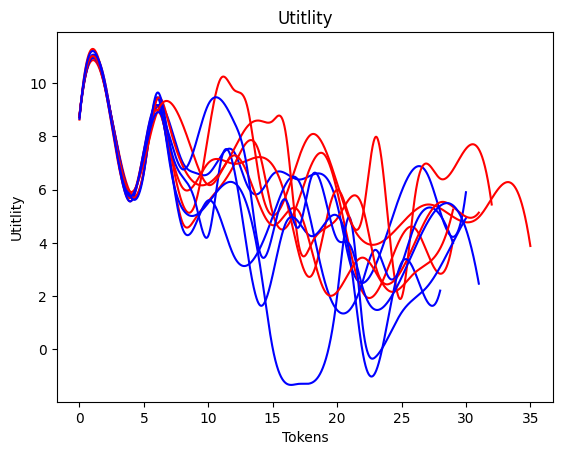

In [36]:
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline

# For smoother curves, define the number of points to be used in the interpolation
n_points = 5000

c0 = 1
layer0 = -21

H_utility = []
for H in H_components_[c0]:
    H =  [h[layer0] for h in H]
    H_utility.append(H)

# Iterate over each list in the H_utility array
for i, h_list in enumerate(H_utility):
    x_values = list(range(len(h_list)))
    
    # Create a smoother curve by interpolating data points
    x_smooth = np.linspace(min(x_values), max(x_values), n_points)
    # spline = make_interp_spline(x_values, h_list, k=3)  # 3rd order spline
    spline = UnivariateSpline(x_values, h_list, s=10)

    y_smooth = spline(x_smooth)
    
    # Plot the list with alternating colors for even and odd indices
    color = "r" if i % 2 == 0 else "b"
    plt.plot(x_smooth, y_smooth, color=color)

# Display legends, title, and the plot
# labels = ["Positive" if i % 2 == 0 else "Negative" for i in range(len(H_utility))]
# plt.legend(labels)
plt.title('Utitlity')
plt.xlabel('Tokens')
plt.ylabel('Utitlity')
plt.show()


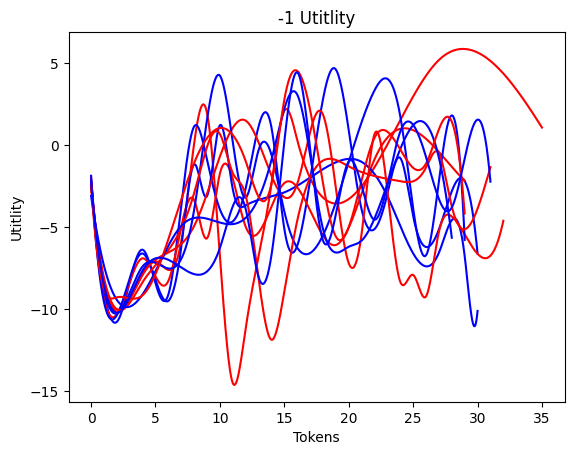

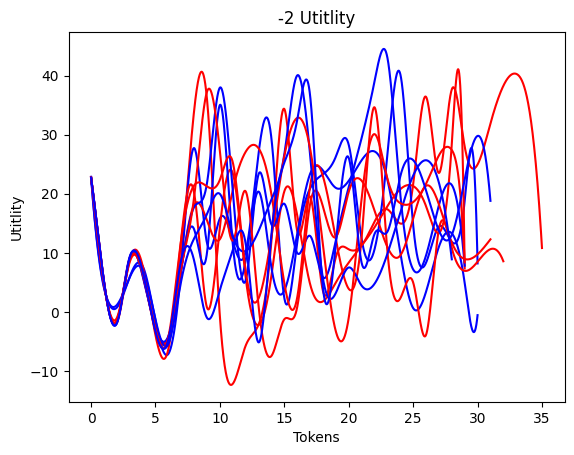

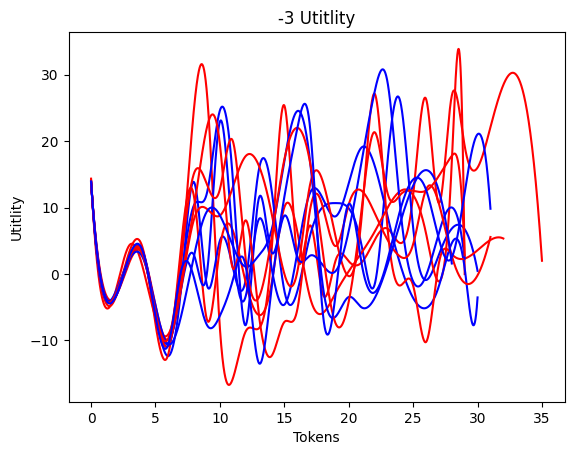

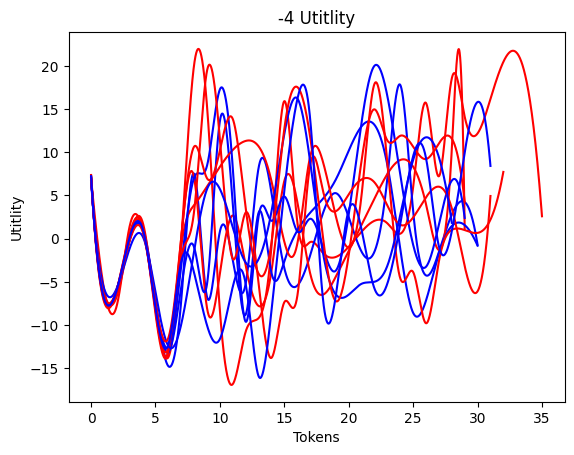

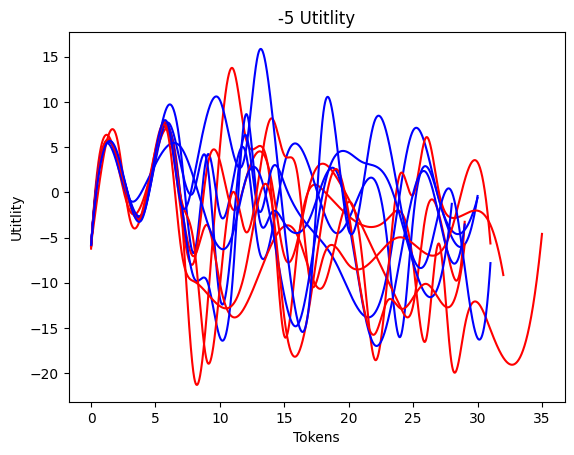

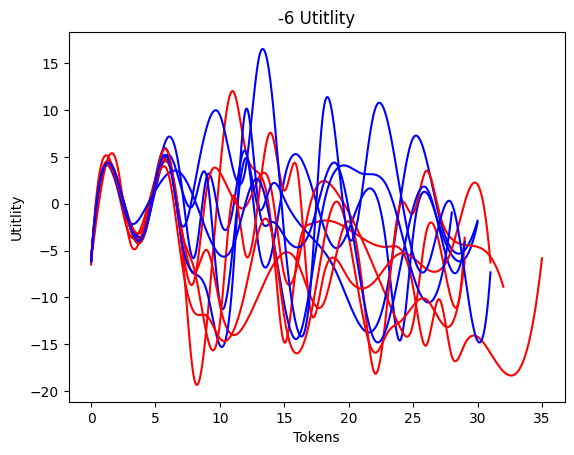

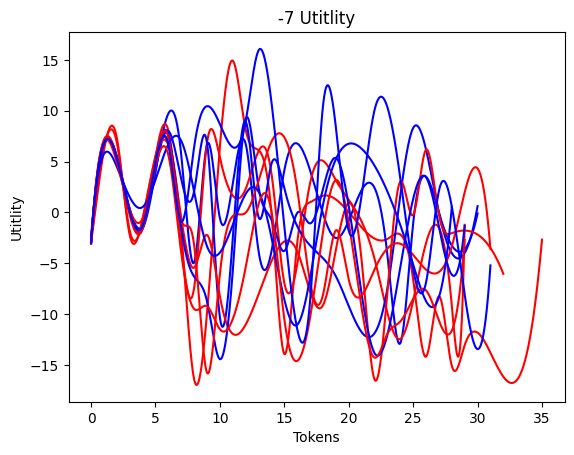

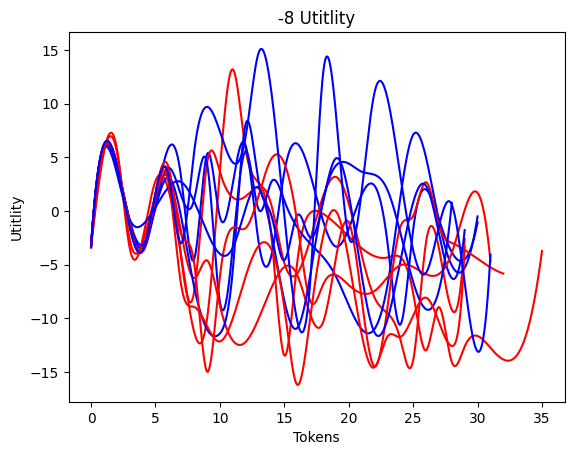

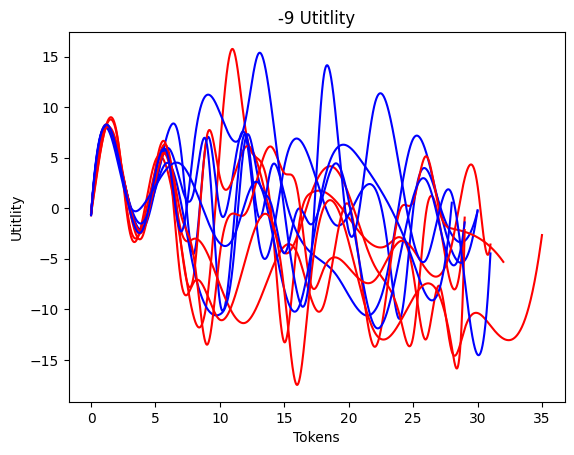

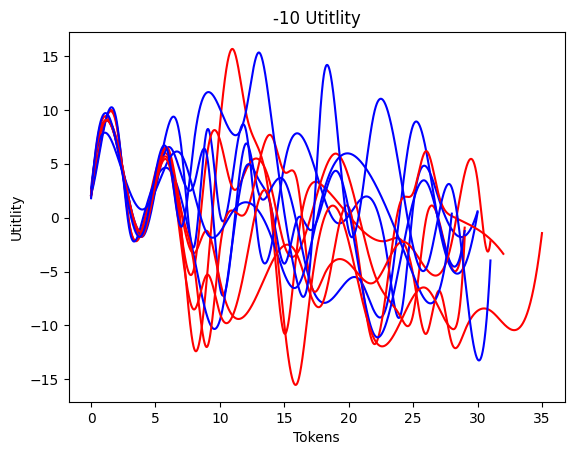

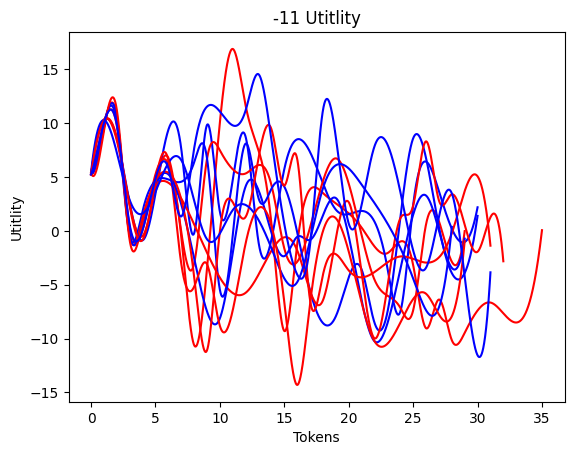

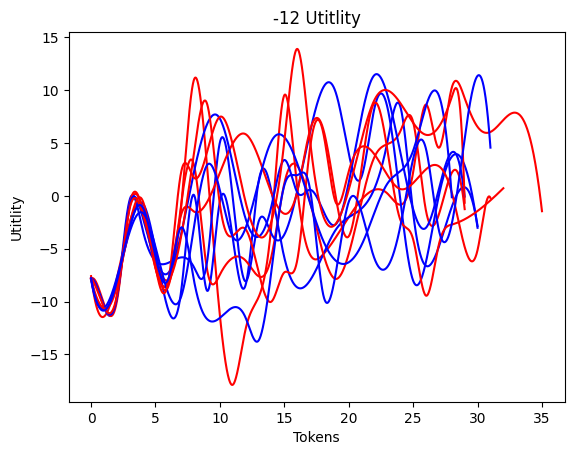

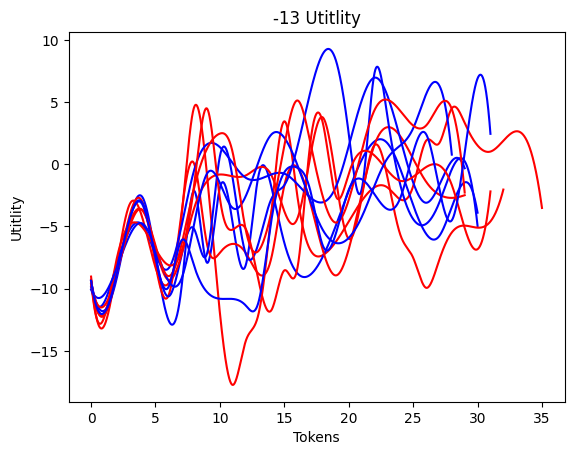

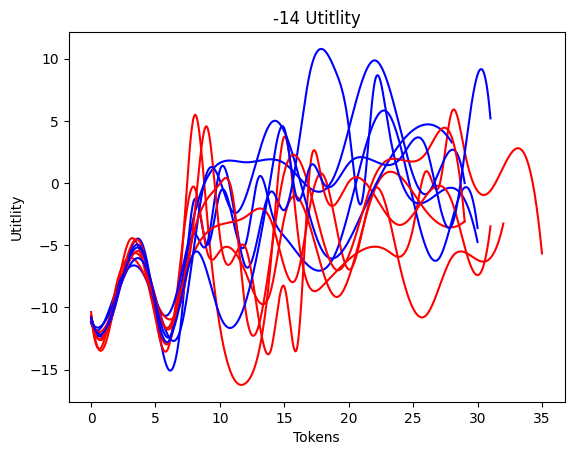

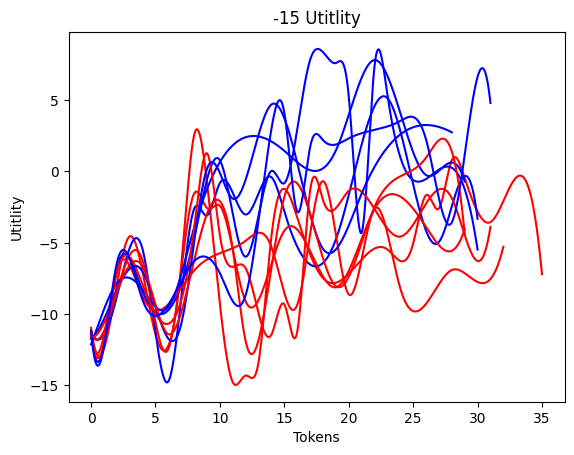

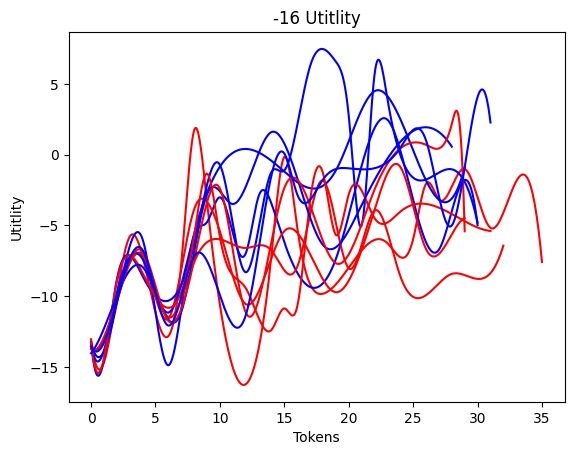

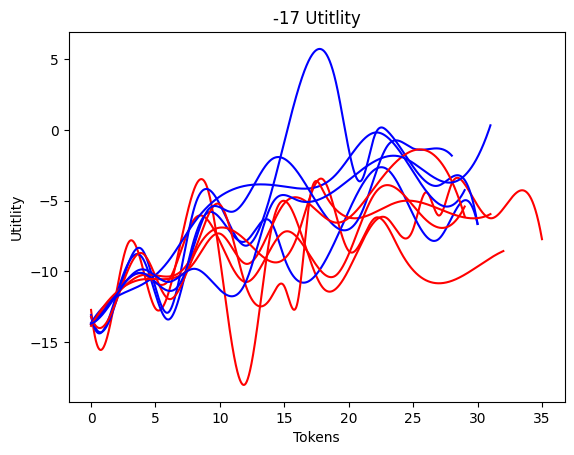

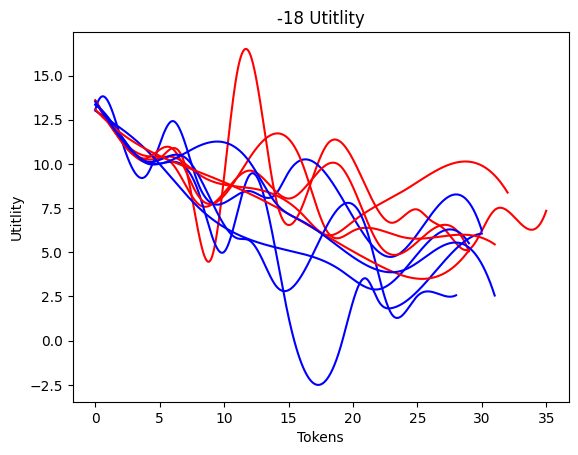

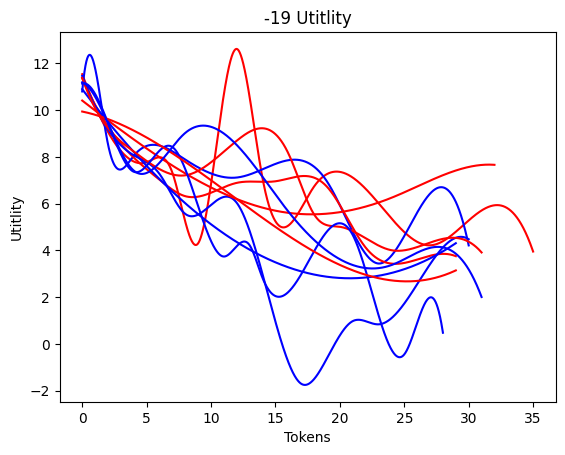

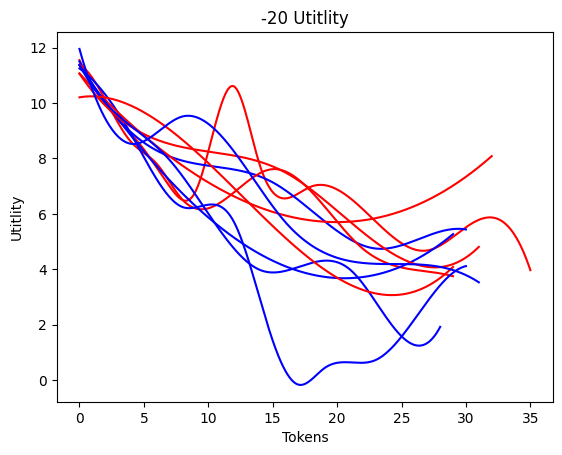

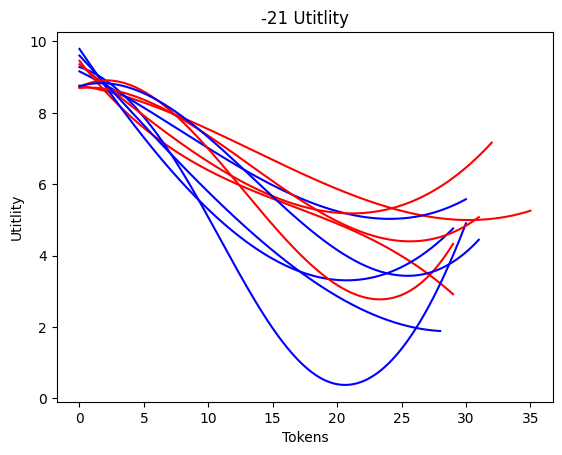

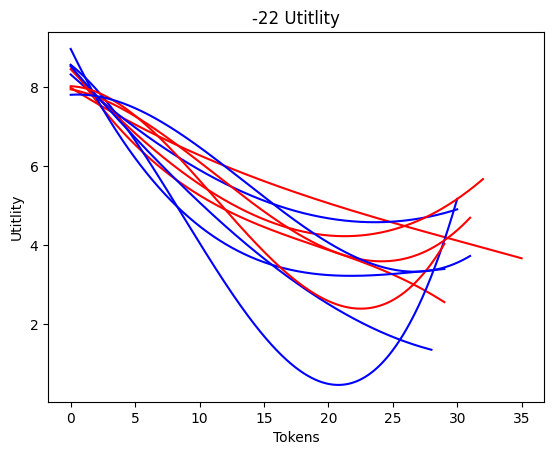

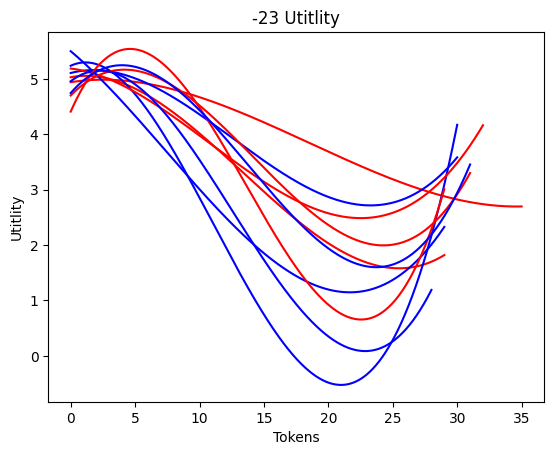

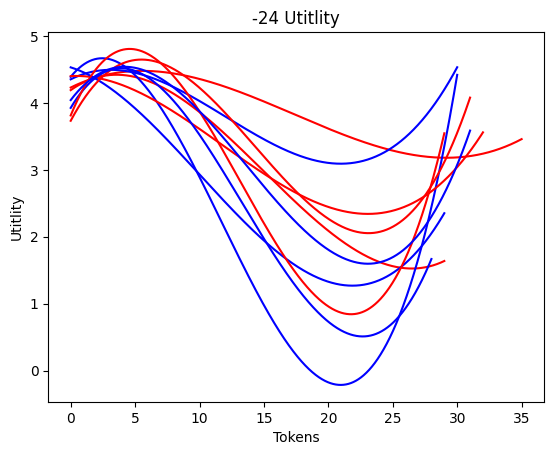

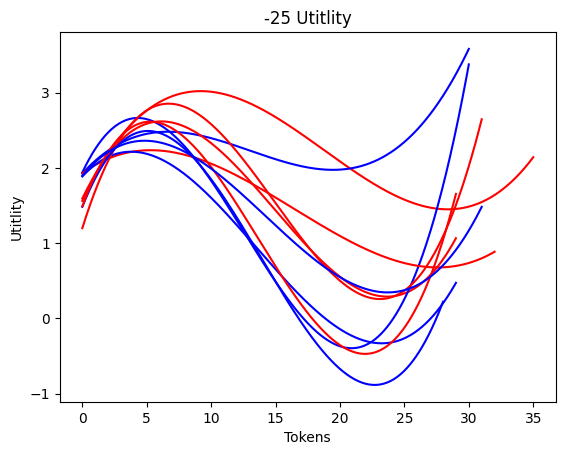

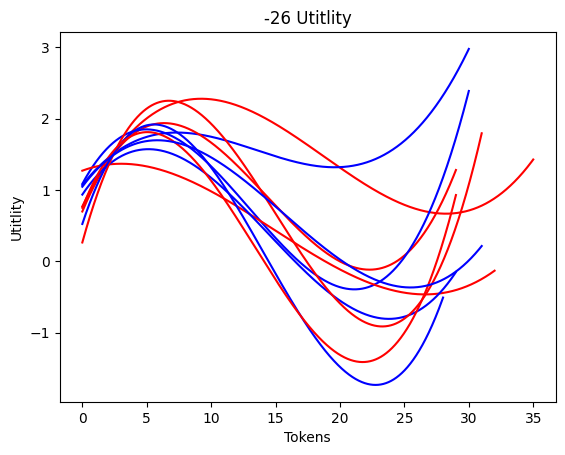

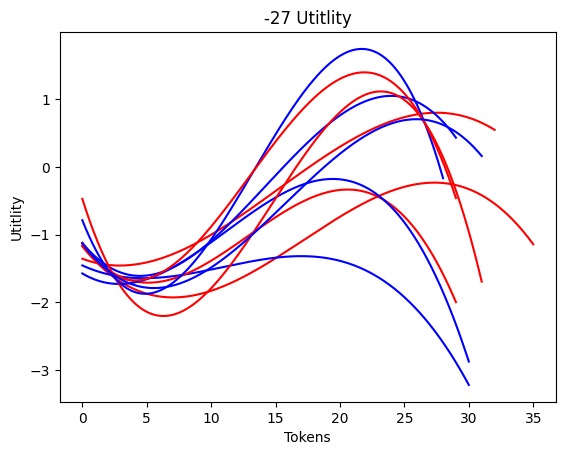

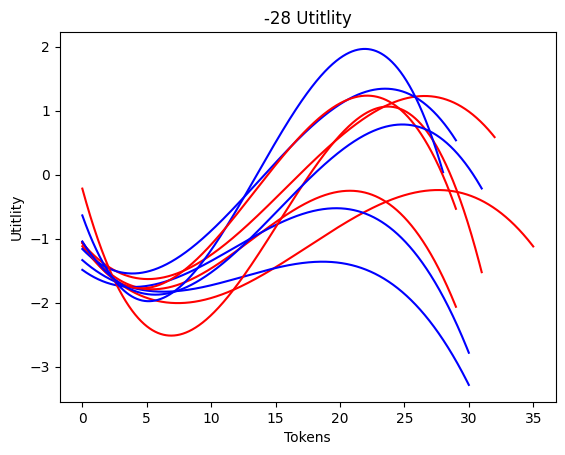

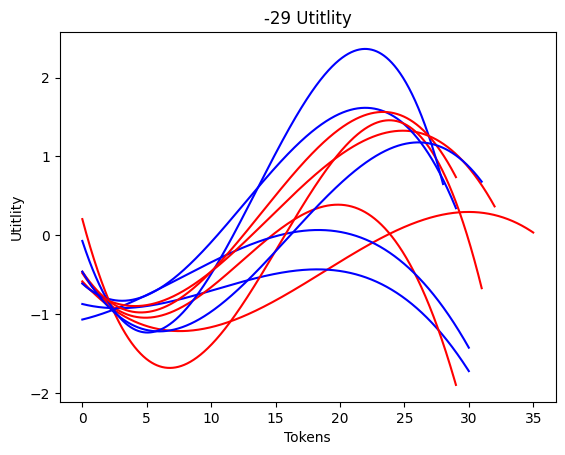

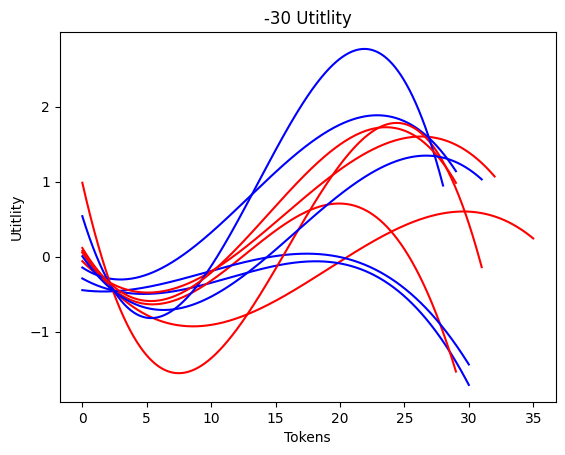

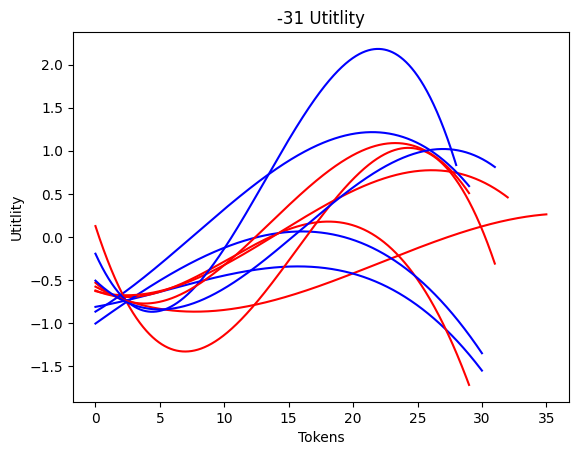

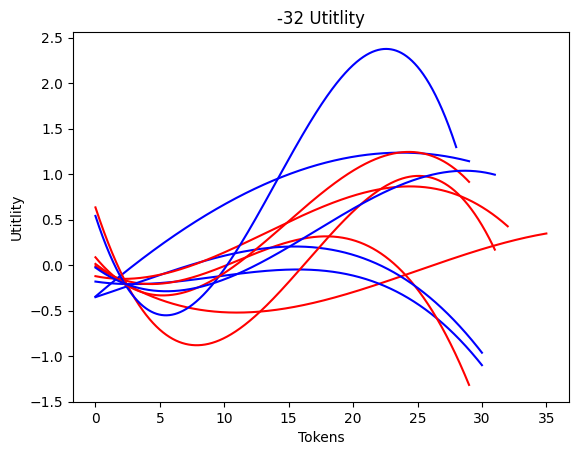

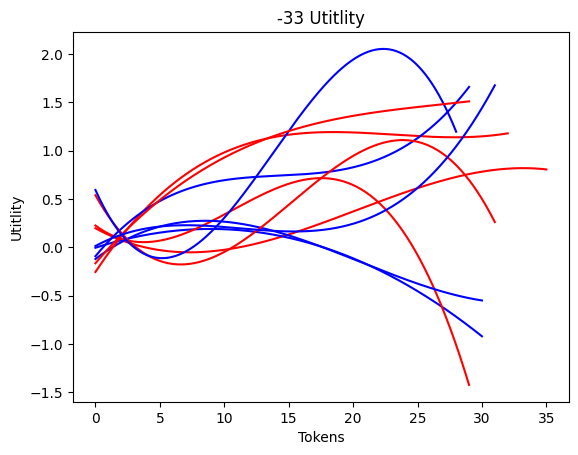

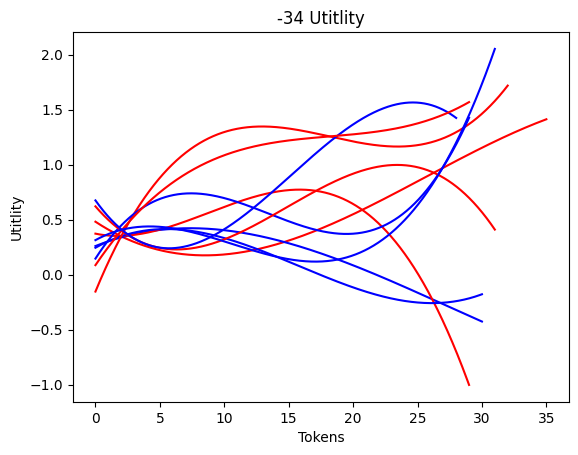

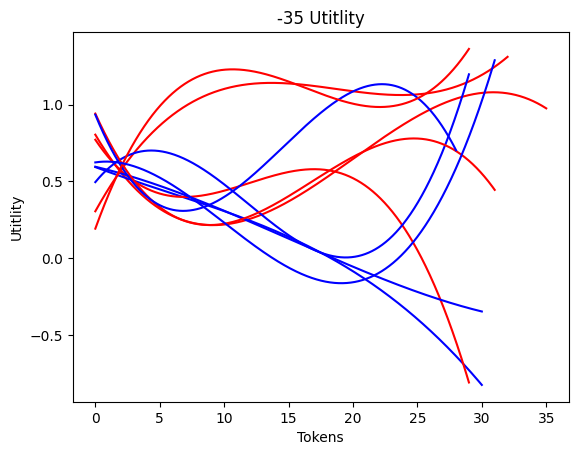

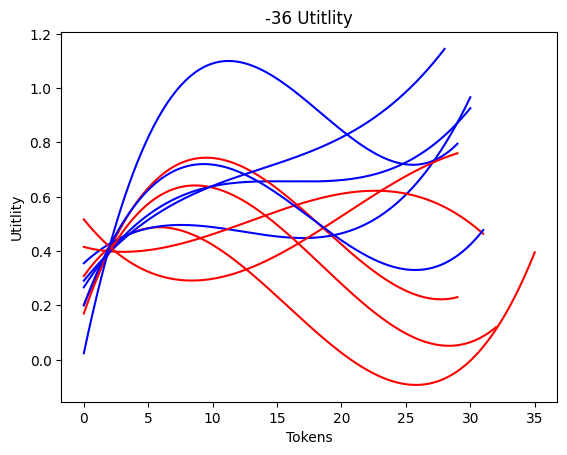

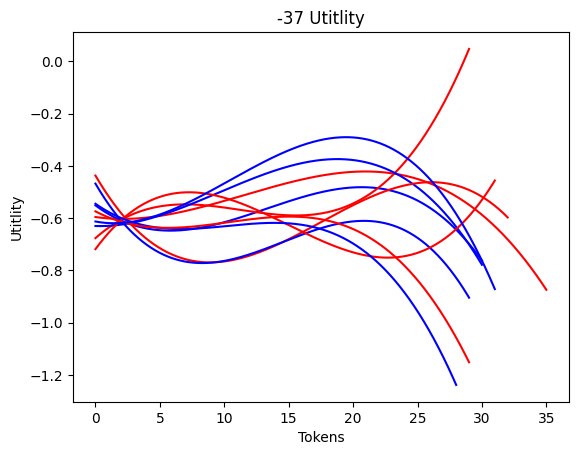

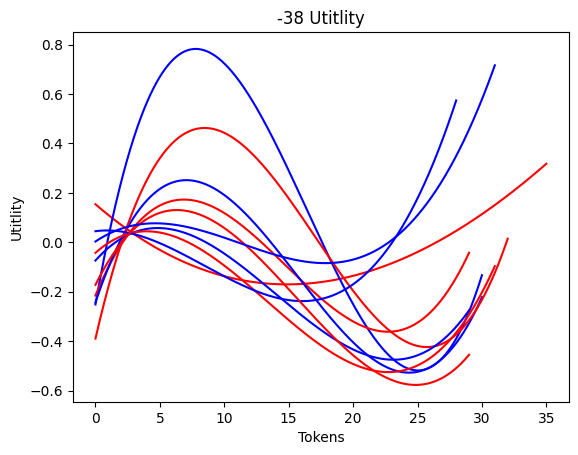

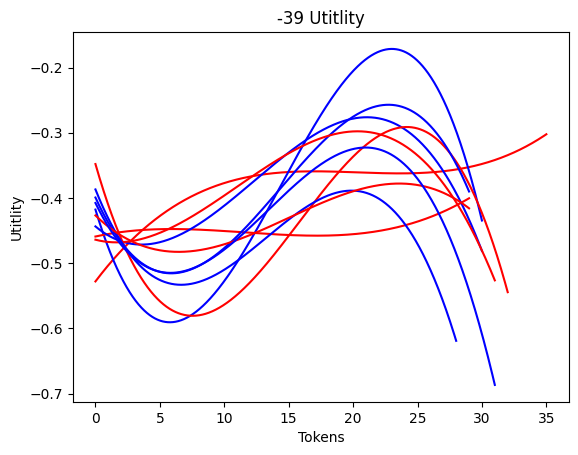

In [37]:
from scipy.interpolate import make_interp_spline

# For smoother curves, define the number of points to be used in the interpolation
n_points = 5000


c0 = 1

for layer in range(-1, -40, -1):

    H_utility = []
    for H in H_components_[c0]:
        H =  [h[layer] for h in H]
        H_utility.append(H)
    
    # Iterate over each list in the H_utility array
    for i, h_list in enumerate(H_utility):
        x_values = list(range(len(h_list)))
        
        # Create a smoother curve by interpolating data points
        x_smooth = np.linspace(min(x_values), max(x_values), n_points)
        # spline = make_interp_spline(x_values, h_list, k=3)  # 3rd order spline
        spline = UnivariateSpline(x_values, h_list, s=100)

        y_smooth = spline(x_smooth)
        
        # Plot the list with alternating colors for even and odd indices
        color = "r" if i % 2 == 0 else "b"
        plt.plot(x_smooth, y_smooth, color=color)
    
    # Display legends, title, and the plot
    # labels = ["Positive" if i % 2 == 0 else "Negative" for i in range(len(H_utility))]
    # plt.legend(labels)
    plt.title(f'{layer} Utitlity')
    plt.xlabel('Tokens')
    plt.ylabel('Utitlity')
    plt.show()


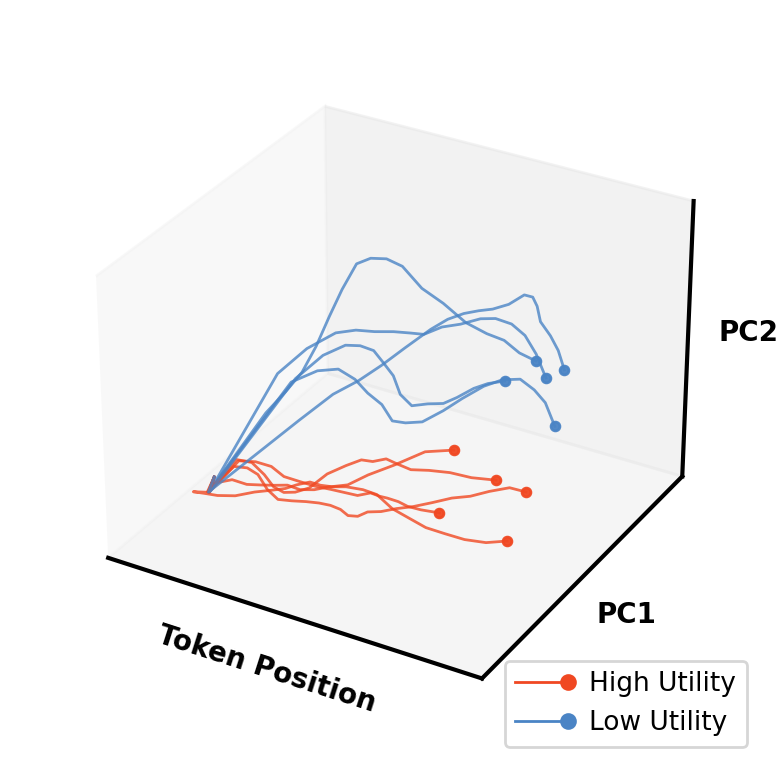

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

def moving_average(data, window_size):
    """Apply moving average to a list."""
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, 'valid')
def gaussian_smooth(data, window_size, sigma=None):
    """Apply Gaussian smoothing to a list."""
    if sigma is None:
        sigma = window_size / 3  # Just a default value, feel free to modify
    
    gaussian_window = np.array([np.exp(-(float(x) / sigma)**2 / 2) for x in range(-(window_size // 2), window_size // 2 + 1)])
    gaussian_window = gaussian_window / sum(gaussian_window)
    return np.convolve(data, gaussian_window, 'valid')


def smooth_from_index(data, window_size, start_index=6, sigma=None):
    """Apply Gaussian smoothing to a list from a specific index."""
    # start = data[:start_index]
    start = gaussian_smooth(data[:start_index], start_index, sigma)
    smoothed = gaussian_smooth(data[start_index:], window_size, sigma)
    return np.concatenate((start, smoothed))

class EndMarkerHandler(HandlerLine2D):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Use the original to create line and marker
        line, = HandlerLine2D.create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans)
        # Adjust the x data of the line to be full width and place the marker at the end
        line.set_data([0, width - xdescent], [height / 2, height / 2])
        line.set_marker('o')
        return [line]
# Your data preparation code here...

fig = plt.figure(figsize=(5, 4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
# ax.set_position([0, 0, 1, 0.9])

c0 = 0
c1 = 1
layer = -17

H_utility = []
for H0, H1 in zip(H_components_[c0], H_components_[c1]):
    H = [[h0[layer], h1[layer]] for h0, h1 in zip(H0, H1)]
    H_utility.append(H)

# Define colors and corresponding labels
color_map = {0: '#F04822', 1: '#4A84C5'}
label_map = {0: 'High Utility', 1: 'Low Utility'}
end_map = {1: "#85CEEC", 0: '#F9A21C'}

even_scores = [test_scores[i][0][0] for i in range(len(test_scores)) if i % 2 == 0]
odd_scores = [test_scores[i][0][0] for i in range(len(test_scores)) if i % 2 == 1]

# Prepare distinct gradient colors
red_colors = [
    '#F9A21C', 
    '#F68B20', 
    '#F16349', 
    '#B02323',
    'r',
]

blue_colors = [
    '#85CEEC', 
    '#3FBAEB', 
    '#6C8EC9', 
    '#4A84C5', 
    'b'
]

# Map scores to colors
even_scores_sorted = sorted(list(set(even_scores)))
odd_scores_sorted = sorted(list(set(odd_scores)))

even_score_to_color = {score.item(): color for score, color in zip(even_scores_sorted, red_colors)}
odd_score_to_color = {score.item(): color for score, color in zip(odd_scores_sorted, blue_colors)}

n_points = 5000
legend_handles = []
window_size = 9
# Iterate over each list in the H_utility array
for i, h_list in enumerate(H_utility):
    # h_list = h_list[3:]
    score = test_scores[i][0][0]
    x_values = list(range(len(h_list)))
    y_values = [item[0] for item in h_list]
    z_values = [item[1] for item in h_list]

    # Spline interpolation for smoother curves
    y_smooth = smooth_from_index(y_values, window_size, start_index=6)
    z_smooth = smooth_from_index(z_values, window_size, start_index=6)
    x_smooth = np.linspace(min(x_values), max(x_values), len(y_smooth))

    if i % 2 == 0:
        gradient_color = even_score_to_color[score.item()]
    else:
        gradient_color = odd_score_to_color[score.item()]

    color_key = i % 2
    color = gradient_color
    color = color_map[color_key]

    line, = ax.plot(x_smooth, y_smooth, z_smooth, color=color, linewidth=1.0, alpha=0.8)
    ax.scatter(x_smooth[-1], y_smooth[-1], z_smooth[-1], c=color, marker='o', s=10, alpha=0.95)  # end

    if (i % 2) not in [handle.get_gid() for handle in legend_handles]:
        # Create a custom line object with a marker at the end for the legend
        custom_line = Line2D([0], [0], color=color, marker='o', markersize=5, markerfacecolor=color, linewidth=1.0)
        custom_line.set_gid(i % 2)
        legend_handles.append(custom_line)
        
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    for tick in axis.get_major_ticks():
        tick.set_pad(-4)
        tick.label.set_fontsize(8)

ax.xaxis.labelpad = -6
ax.yaxis.labelpad = -6
ax.zaxis.labelpad = -6

# ax.set_title('Utility', fontsize=12, fontweight="bold")
ax.set_xlabel('Token Position', fontsize=10, fontweight='bold')
ax.set_ylabel(f'PC{c0+1}', fontsize=10, fontweight='bold')
ax.set_zlabel(f'PC{c1+1}', fontsize=10, fontweight='bold')
ax.grid(True)

for axis in ['x', 'y', 'z']:
    ax.w_xaxis.line.set_color((0.0, 0.0, 0.0, 1.0))  # Set x-axis color to black (can be adjusted)
    ax.w_xaxis.line.set_linewidth(1.5)  # Set x-axis line width
    ax.w_yaxis.line.set_color((0.0, 0.0, 0.0, 1.0))  # Set y-axis color to black (can be adjusted)
    ax.w_yaxis.line.set_linewidth(1.5)  # Set y-axis line width
    ax.w_zaxis.line.set_color((0.0, 0.0, 0.0, 1.0))  # Set z-axis color to black (can be adjusted)
    ax.w_zaxis.line.set_linewidth(1.5)  # Set z-axis line width

# ax.view_init(elev=45)  # Adjust the values as needed

# Legend
handlers = [EndMarkerHandler(numpoints=1) for handle in legend_handles]
ax.legend(handles=legend_handles, labels=[label_map[handle.get_gid()] for handle in legend_handles], loc="lower right", handler_map={Line2D: EndMarkerHandler()}, prop={'size': 9.5})
ax.set_box_aspect(aspect=None, zoom=0.9)

plt.tight_layout()

plt.savefig('figures/utility_neurons_path.pdf', bbox_inches="tight")

plt.show()
